In [7]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import GPT2TokenizerFast

/n/home08/bbordelon/.conda/envs/flax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
print(load_dataset('squad', split='train')[0])

{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}


In [118]:
MAX_LEN = 128 # length of the context window (consider making this longer)
BATCH_SIZE = 256 # size of the batches

ds = load_dataset('c4', 'en', split='train', streaming = True)
#ds = ds.with_format('jax')
shuff_ds = ds.shuffle(seed = 0, buffer_size = 20000)

tokenizer = GPT2TokenizerFast.from_pretrained("openai-community/gpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# encoder function: GPT byte encoding
def encode(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length = MAX_LEN)

dataset = shuff_ds.map(encode, batched=True, batch_size = BATCH_SIZE, remove_columns=["timestamp", "url"])

/n/home08/bbordelon/.conda/envs/flax/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for c4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/c4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/n/home08/bbordelon/.cache/huggingface/modules/datasets_modules/datasets/c4/584d57ebe81c209b6c7f31727066d2c4b4bba37cb7092cdd83083d5ec11207db/c4.py:53: FutureWarning: Dataset 'c4' is deprecated and will be deleted. Use 'allenai/c4' instead.
  warnings.warn(


In [119]:
VOCAB_SIZE = len(tokenizer)

print("Vocabulary")
print(VOCAB_SIZE)


Vocabulary
50258


In [120]:
import jax.numpy as jnp
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
import numpy as np

# collate without mlm

collate_fn = lambda x: np.array([xi["input_ids"] for xi in x])

#dataloader = DataLoader(dataset, collate_fn=DataCollatorForLanguageModeling(tokenizer, mlm=False))
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, collate_fn = collate_fn)

for i,batch in enumerate(dataloader):
    
    print(batch.shape)
    print(batch)
    
    if i == 0:
        break

(256, 128)
[[  464  5690   389 ... 50257 50257 50257]
 [25206   287   534 ...   828   345   460]
 [ 2953   257   640 ...   602    13   843]
 ...
 [11006   468   587 ... 34685   739    12]
 [ 6187    13 31942 ...   540  3957 32858]
 [13448 18014   422 ...   262  3572   286]]


In [74]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import matplotlib.pyplot as plt
from flax.linen.activation import softmax
from einops import rearrange
from jax import random, value_and_grad
from jax.example_libraries import optimizers
import optax
import sys

In [16]:
print(jax.devices()) # hopefully sees cuda device

[cuda(id=0)]


In [22]:
X = jnp.ones((50,50))
print(X.shape)
print(X.devices())

(50, 50)
{cuda(id=0)}


In [40]:
causal_mask = jnp.ones((MAX_LEN, MAX_LEN))
lower = jnp.tril(causal_mask)
causal_mask = jnp.triu(causal_mask, k=1)
causal_mask = lower + -jnp.inf * (causal_mask > 0.0)
print(causal_mask)

[[  1. -inf -inf ... -inf -inf -inf]
 [  1.   1. -inf ... -inf -inf -inf]
 [  1.   1.   1. ... -inf -inf -inf]
 ...
 [  1.   1.   1. ...   1. -inf -inf]
 [  1.   1.   1. ...   1.   1. -inf]
 [  1.   1.   1. ...   1.   1.   1.]]


In [121]:
class Causal_Attention(nn.Module):

    scale_exp: jnp.float32
    dim: int
    heads: int
    
    def setup(self):
        
        self.c = 1.5 - self.scale_exp # exponent for the scale factor
        kif_qk = nn.initializers.normal(stddev = self.dim**(self.c - 0.5) ) # possibly needs to be scaled with N
        kif_v =  nn.initializers.normal(stddev = 1.0 ) # O_N(1) entries
        # computes key, query, value
        self.qk_layer = nn.Dense(features = 2 * self.heads * self.dim, kernel_init = kif_qk)
        self.v_layer = nn.Dense(features = self.heads * self.dim, kernel_init = kif_v)
        
        return
    
    def __call__(self,inputs):
        
        qk = self.qk_layer(inputs) / inputs.shape[-1]**(self.c)  # (batch, loc, 3*h*d)
        qk = rearrange( qk, 'b l (h d) -> b h l d' , h = self.heads) # (batch, heads, loc, d )
        q,k = jnp.split(qk, 2, axis = -1) # gives q, k each of shape ( batch, heads, loc, d )
        v = self.v_layer(inputs) / jnp.sqrt( inputs.shape[-1] )
        v = rearrange(v, 'b l (h d) -> b h l d', h = self.heads)
        
        A = 1.0/ self.dim**(self.scale_exp) * jnp.einsum('ijkl,ijml->ijkm', q, k) # batch x heads x loc x loc
        exp_A =  jnp.einsum('ijkl,kl->ijkl', jnp.exp(A), jnp.tril(jnp.ones((v.shape[2], v.shape[2]))))
        phi_A = exp_A / exp_A.sum(axis = -1)[:,:,:,jnp.newaxis]  
        
        out = jnp.einsum('ijkl,ijlm->ijkm', phi_A, v) # (batch, head, loc, d)  
        out = rearrange(out, 'b h l d -> b l (h d)')
        return out
    
    
class MLP_Block(nn.Module):

    features: int
    
    @nn.compact
    def __call__(self,x):
        N = self.features
        kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries
        h = nn.Dense(features = 4*N, kernel_init = kif)(x) / jnp.sqrt(N)
        h = nn.relu(h)
        h = nn.Dense(features = N, kernel_init = kif)(x) / jnp.sqrt(4*N)
        return h
    

class Transformer(nn.Module):
    """A simple Decoder only transformer"""
  
    dim: int
    heads: int
    depth: int
    scale_exp: jnp.float32
    adam_scale: int
    beta: jnp.float32

    @nn.compact
    def __call__(self, x, train = True):
        N = self.heads * self.dim
        
        kif_first= nn.initializers.normal(stddev = N**(-0.5*self.adam_scale) ) # O_N(1) entries
        kif0 = nn.initializers.normal(stddev = 0.0 )
        kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries
        
        ### TODO: add positional encoding
        
        # embed the batch x sequence integers to 
        x = N**(0.5 * self.adam_scale) * nn.Embed(VOCAB_SIZE, N, embedding_init = kif_first)(x) # batch x seq len x N
        x = nn.relu(x)
        for l in range(self.depth):
            h = nn.LayerNorm()(x)
            x = x + self.beta/jnp.sqrt(depth) * Causal_Attention(dim = self.dim, scale_exp = self.scale_exp, heads = self.heads)(h)
            h = nn.LayerNorm()(x)
            x = x + self.beta/jnp.sqrt(depth) * MLP_Block(features = N)(h)
            
        x = nn.LayerNorm()(x)
        x = nn.Dense(features = VOCAB_SIZE, use_bias = False, kernel_init = kif)(x) / N**(1.0-0.5*self.adam_scale)   # for mean field scaling
        return x

In [123]:
dim = 32
heads = 12
depth = 12
scale_exp = 1.0
adam = True
beta = 6.0

lr = 0.1
gamma = 0.25

if adam:
    adam_scale = 1
    optimizer = optax.adam( lr / jnp.sqrt(heads*dim)  )
else:
    adam_scale = 0
    optimizer = optax.sgd( heads * dim * gamma**2 *  lr)

model = Transformer(dim, heads,depth, scale_exp = scale_exp, adam_scale = adam_scale, beta = beta)
params = model.init(random.PRNGKey(0), jnp.ones((32,128), dtype = jnp.int32)) 
loss_fn = jax.jit(lambda params, Xb, yb: optax.softmax_cross_entropy_with_integer_labels(logits=model.apply(params, Xb), labels=yb).mean())
val_grad_fn = jax.jit(value_and_grad(loss_fn))

opt_state = optimizer.init(params)

run_loss = 0.0

T = 5000
losses = []

for t,batch in enumerate(dataloader):
    
    loss, grads = val_grad_fn(params, batch[:,:-1], batch[:,1:])
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    #run_loss = loss
    run_loss =  t/(t+1) * run_loss + 1/(t+1) * loss
    sys.stdout.write(f'\r loss = {run_loss}')
    losses += [run_loss]
    if t > T:
        break

 loss = nan811587333679265

KeyboardInterrupt: 

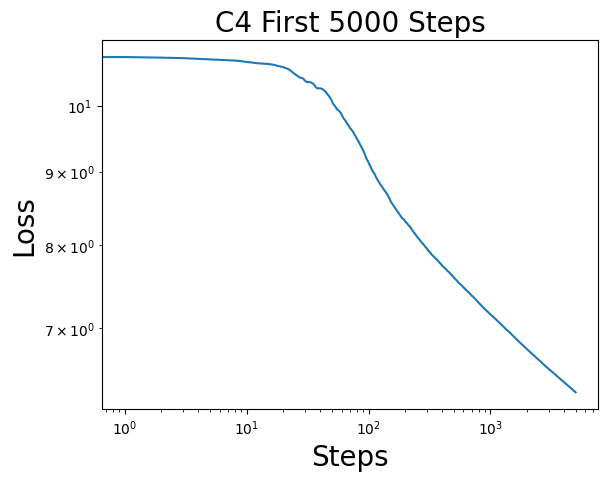

In [108]:
plt.loglog(losses)
plt.xlabel('Steps', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title(f'C4 First {T} Steps',fontsize = 20)
plt.show()

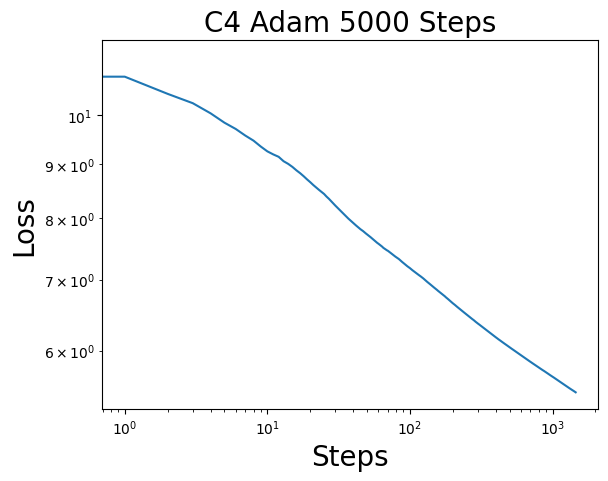

In [125]:
plt.loglog(losses)
plt.xlabel('Steps', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title(f'C4 Adam {T} Steps',fontsize = 20)
plt.show()

In [127]:
def train_model(param_args, opt_args, data = None, adam = False):
    
    dim, heads, depth,scale_exp, beta = param_args
    lr , gamma, T = opt_args
    
    if adam:
        adam_scale = 1
        optimizer = optax.adam( lr / jnp.sqrt(heads*dim)  )
    else:
        adam_scale = 0
        optimizer = optax.sgd( heads * dim * gamma**2 *  lr)

    model = Transformer(dim, heads,depth, scale_exp = scale_exp, adam_scale = adam_scale, beta = beta)
    params = model.init(random.PRNGKey(0), jnp.ones((32,128), dtype = jnp.int32)) 
    loss_fn = jax.jit(lambda params, Xb, yb: optax.softmax_cross_entropy_with_integer_labels(logits=model.apply(params, Xb), labels=yb).mean())
    val_grad_fn = jax.jit(value_and_grad(loss_fn))


    opt_state = optimizer.init(params)

    run_loss = 0.0

    T = 5000
    losses = []

    for t,batch in enumerate(dataloader):
    
        loss, grads = val_grad_fn(params, batch[:,:-1], batch[:,1:])
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        run_loss = loss
        #run_loss =  t/(t+1) * run_loss + 1/(t+1) * loss
        sys.stdout.write(f'\r loss = {run_loss}')
        losses += [run_loss]
        if t > T:
            break
    return losses


In [128]:
dim = 32
heads = 12
depth = 6
scale_exp = 1.0
adam = True
beta = 4.0

lr = 0.025
gamma = 0.5

dims = [32,64,128]
T = 1000

all_losses = []

for i,dim in enumerate(dims):
    param_args = (dim, heads, depth,scale_exp,beta)
    opt_args = (lr, gamma, T)
    print(" ")
    print(f"dim = {dim}")
    all_losses += [ train_model(param_args, opt_args, data = None, adam = True) ]

dim = 32
 loss = 4.929401874542236dim = 64
 loss = 4.825812339782715dim = 128
 loss = nan306570053100595

In [129]:
for i,loss in enumerate(all_losses):
    plt.loglog(loss, label = f'N = {dims[i]}')
plt.legend()
plt.xlabel('Steps', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title(f'C4 Adam {T} Steps',fontsize = 20)
plt.tight_layout()
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'loglgo'